In [1]:
import scanpy as sc, dynamo as dyn, scvelo as scv, pandas as pd, numpy as np


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/csj/anaconda3/envs/celltensor/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


# load data

In [2]:
idata = sc.read_h5ad('./full-alp.final.h5ad')
idata = idata[idata.obs.batch=='FL'].copy()
idata.obs_names=[s[0]for s in idata.obs_names.str.split("-")]


adata=sc.read_h5ad('/home/csj/mywork/ilc/220409-preprocessed_data/220516-FL.velo.h5ad')
adata = adata[idata.obs_names].copy()
adata.obsm['X_umap'] = idata[adata.obs_names].obsm['X_umap'].copy()
adata.obs['leiden'] = idata[adata.obs_names].obs['leiden']

In [12]:
palette= {'0':'#E5B1D1',"1":'#B8818F','2':'#CB393C',
    "5":'#2F2B54',"6":'#2C6D9E','9':'#EA993A',
    '3':'#B3BA43','7':'#55C29E','4':"#286251",'8':'#923698'}

|-----------> plotting with basis key=X_umap
|-----------> skip filtering phase by stack threshold when stacking color because it is not a numeric type


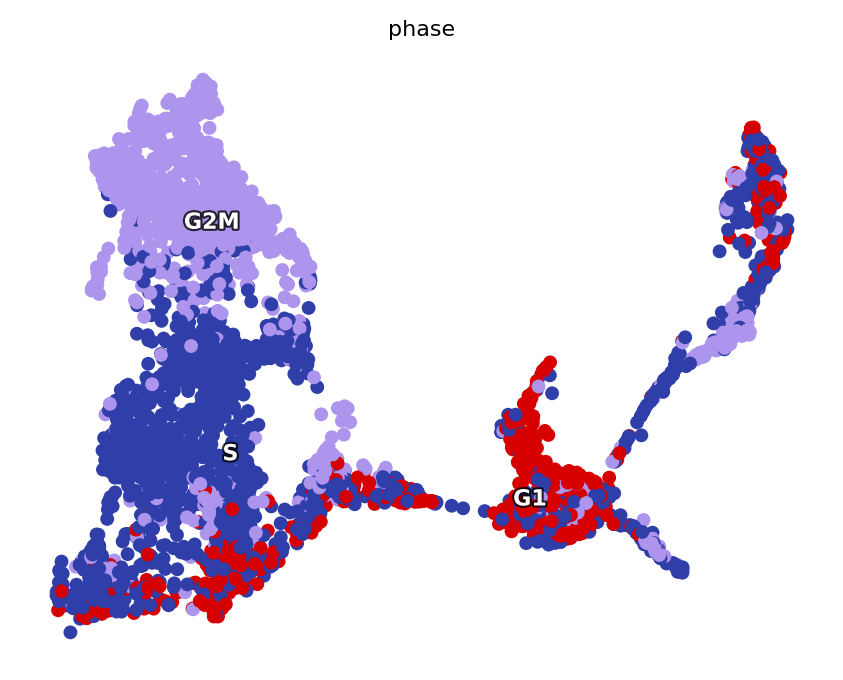

|-----------> plotting with basis key=X_umap
|-----------> skip filtering ann0608 by stack threshold when stacking color because it is not a numeric type


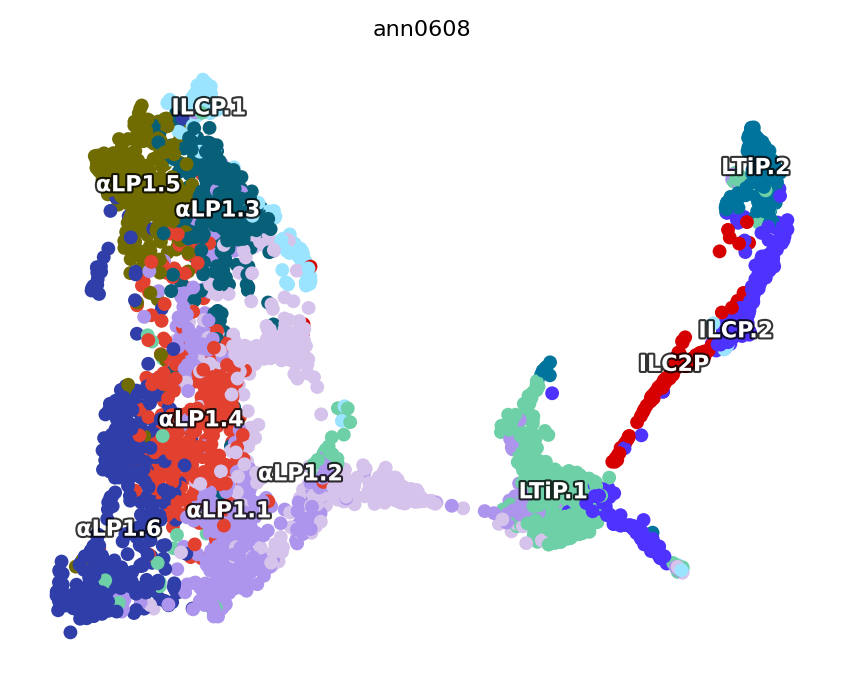

In [4]:
dyn.pl.scatters(adata,basis='umap', color='phase', alpha=1, pointsize=0.1)
#dyn.pl.scatters(adata,basis='umap', color='cell_cycle_phase', alpha=0.61, pointsize=0.11, show_legend=True,
#               color_key={'G1-S':'red','S':'orange','G2-M':'yellow','M':'green','M-G1':'cyan'})
dyn.pl.scatters(adata,basis='umap', color='ann0608', alpha=1, pointsize=0.1)

# velocity pp

In [5]:
# preprocess data 
## - detect experiment type
## - set expression matrix
## - detect if normalized/log1p 
## - setting QC thresholds
## - calculating variable genes
## - calculating size factors and normalize
## - pca
## - cell-cycle scoring
goi = [ "Id2","Ncor1","Nfil3","Zbtb16","Rora","Runx3","Runx2","Runx1",
        "Cbfb","Tox","Was","Zbtb1","Zbtb46","Zeb2",
        "Rorc","Ahr","Maf","Ikzf1","Ikzf3","Nr1d1","Zfp292","Batf3",
        "Bcl11b","Myc","Gata3","Gfi1","Tbx21","Eomes","Irf8","Bhlhe40",
        "Notch1","Notch2","Rbpj","Tcf7","Hes1","Dtx1",
        "Zbtb16",'Ccr6' ]
dyn.pp.recipe_monocle(adata, genes_to_append=goi, genes_to_exclude=['Malat1'])


|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----------> <insert> tkey to uns['

In [6]:
adata_bkup = adata.copy()

|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [28.2087s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False


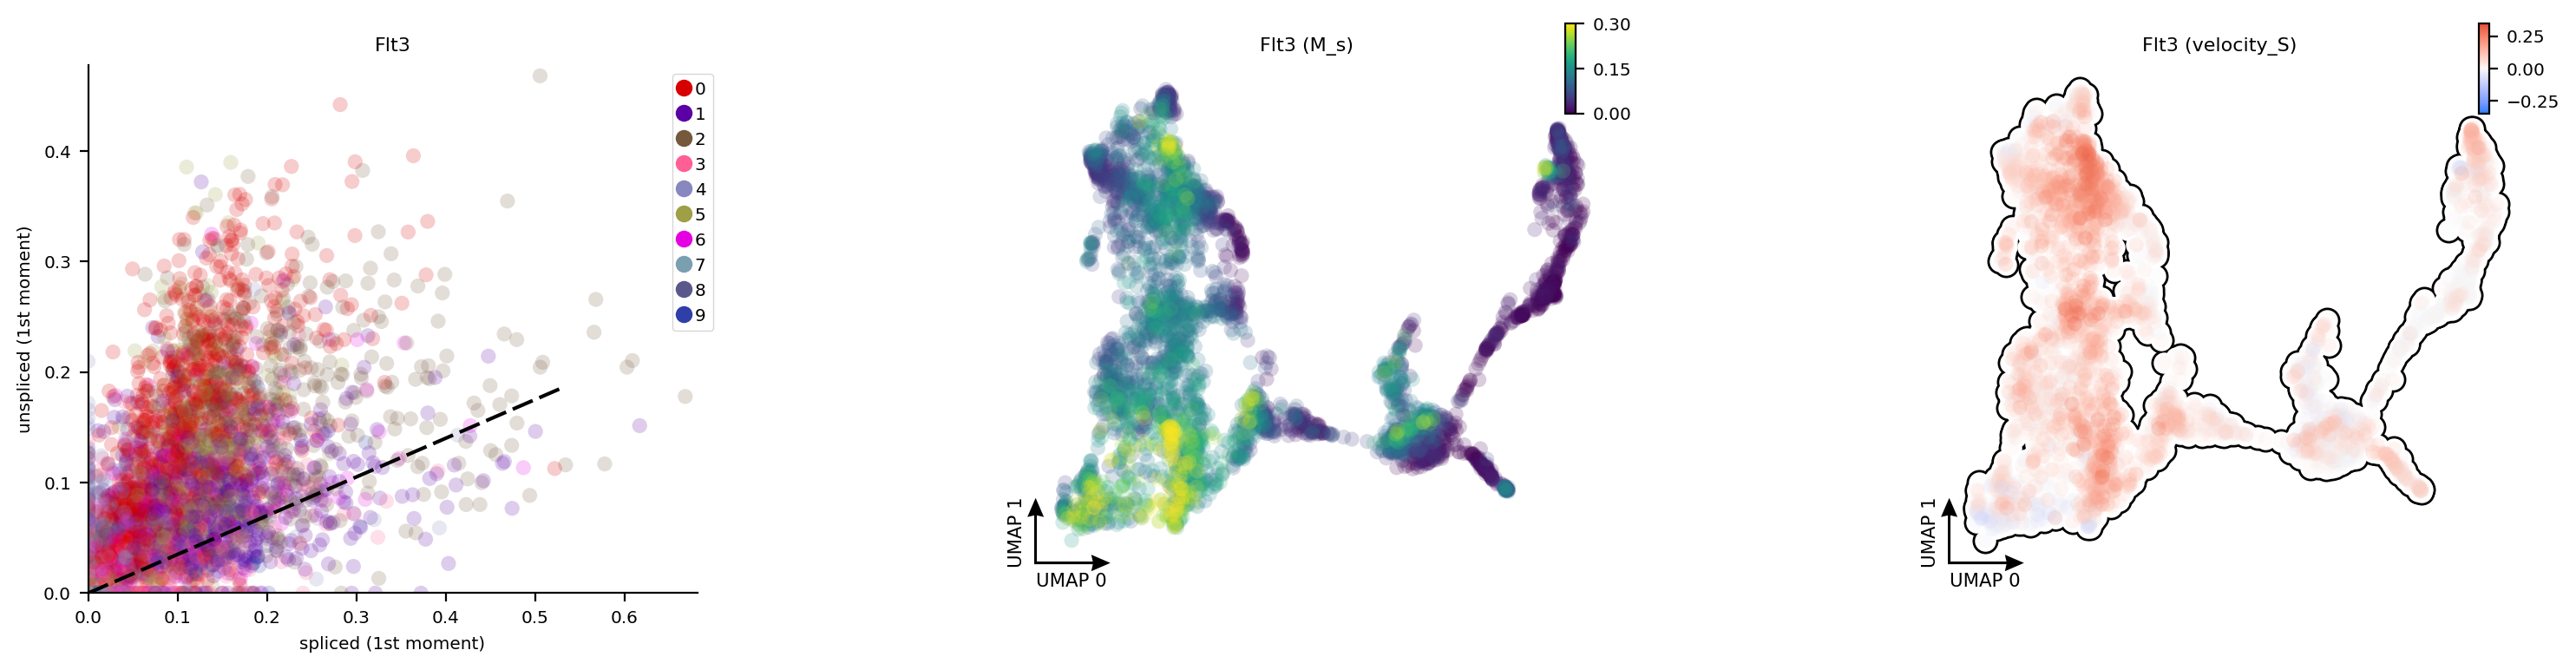

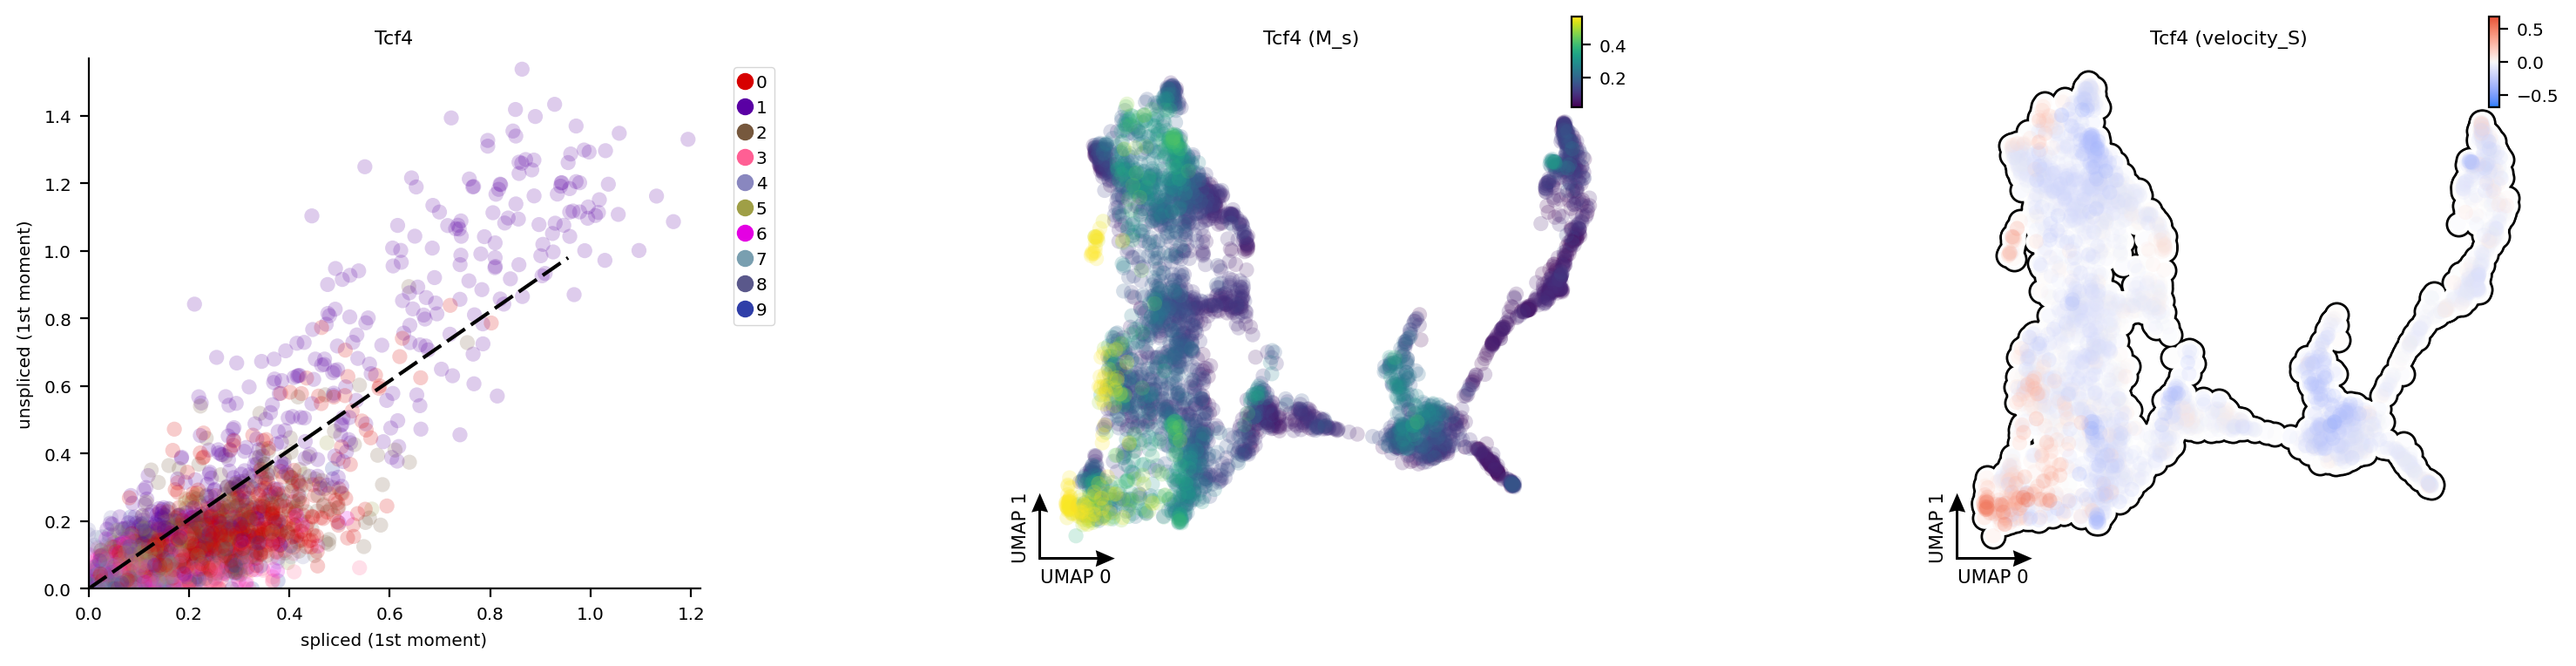

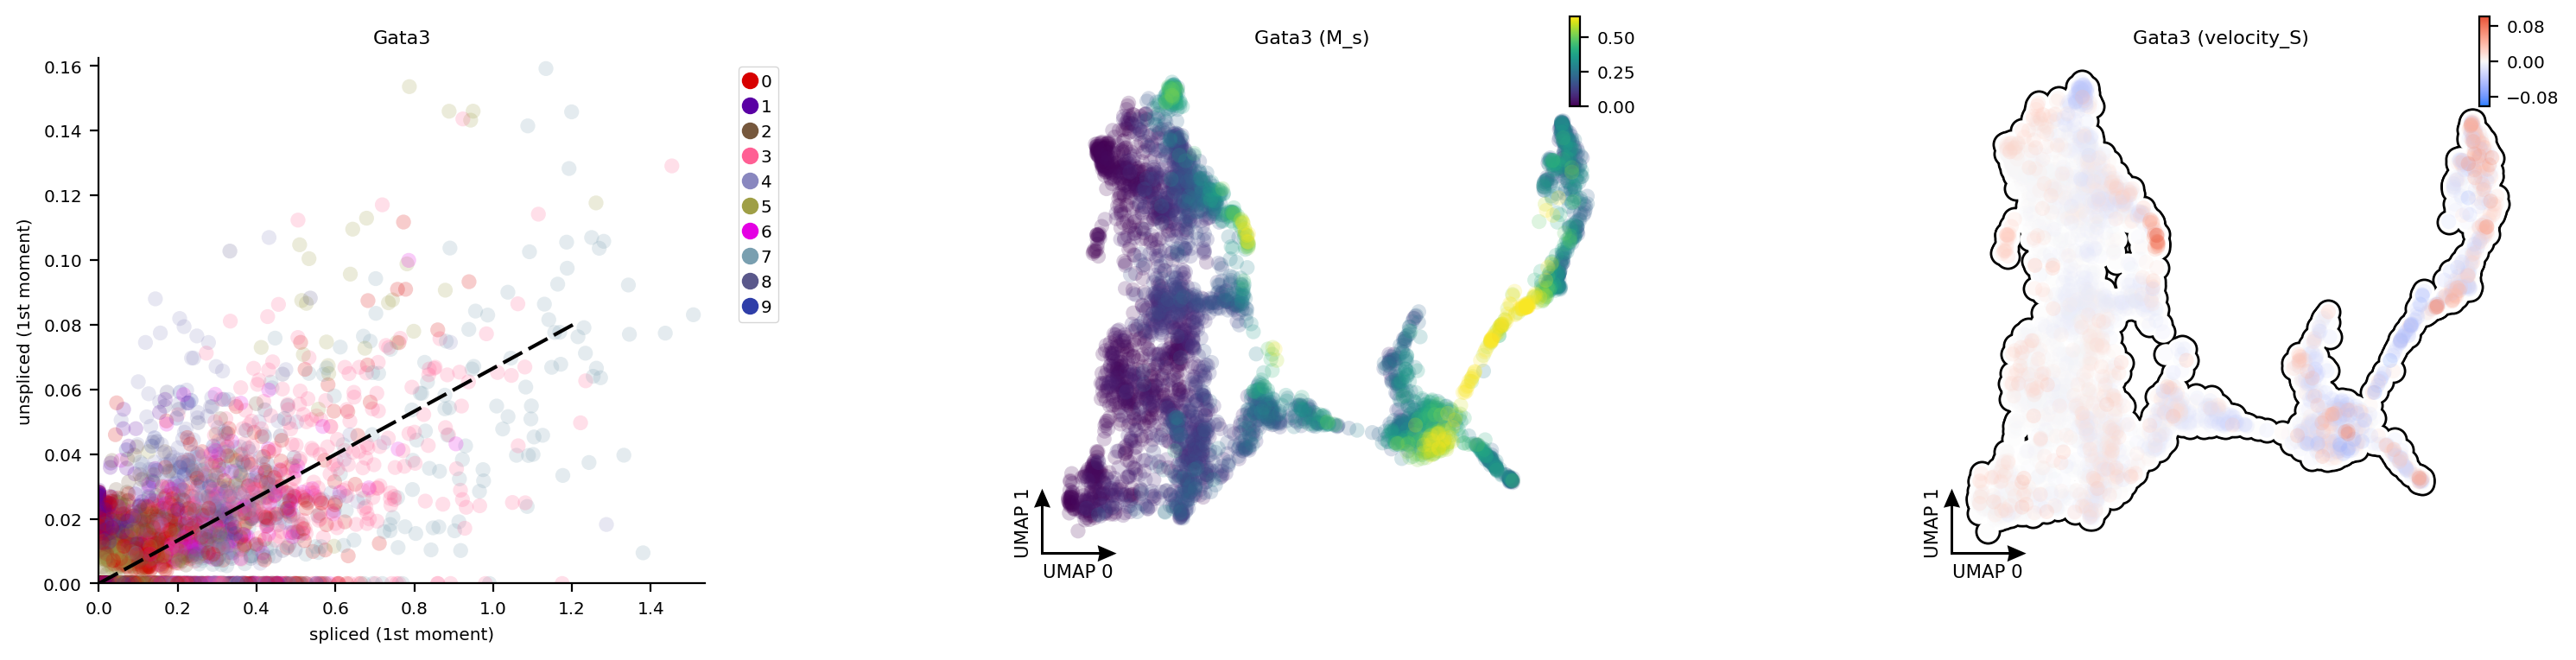

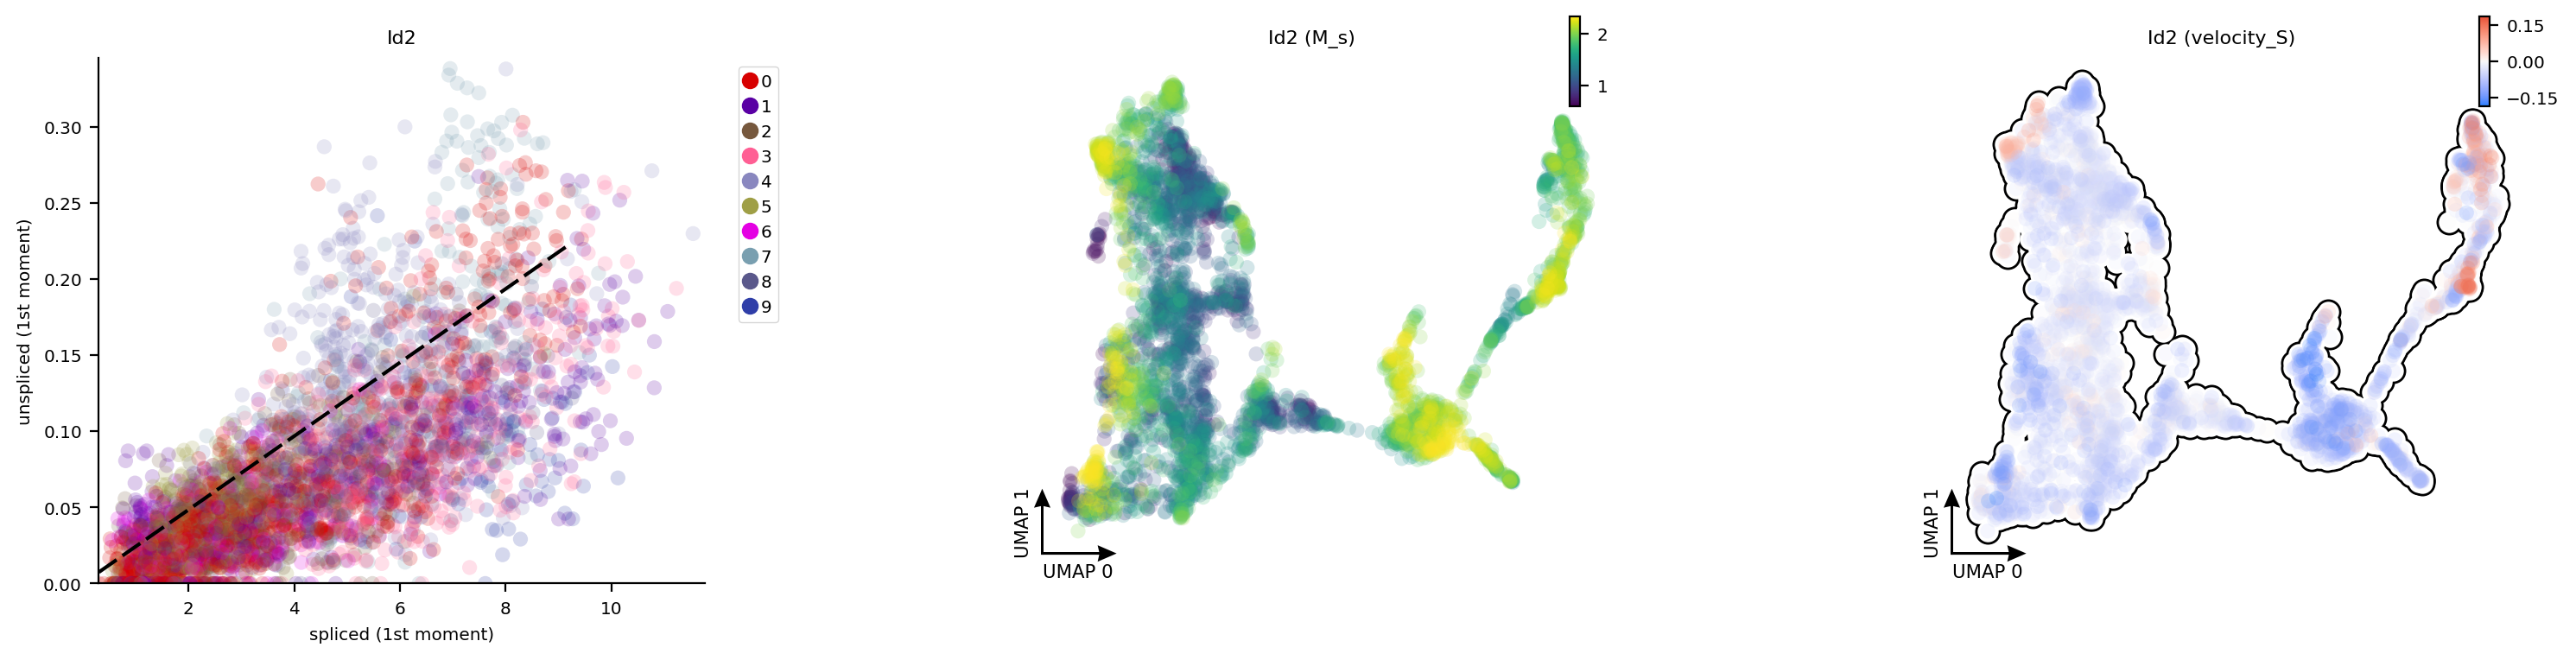

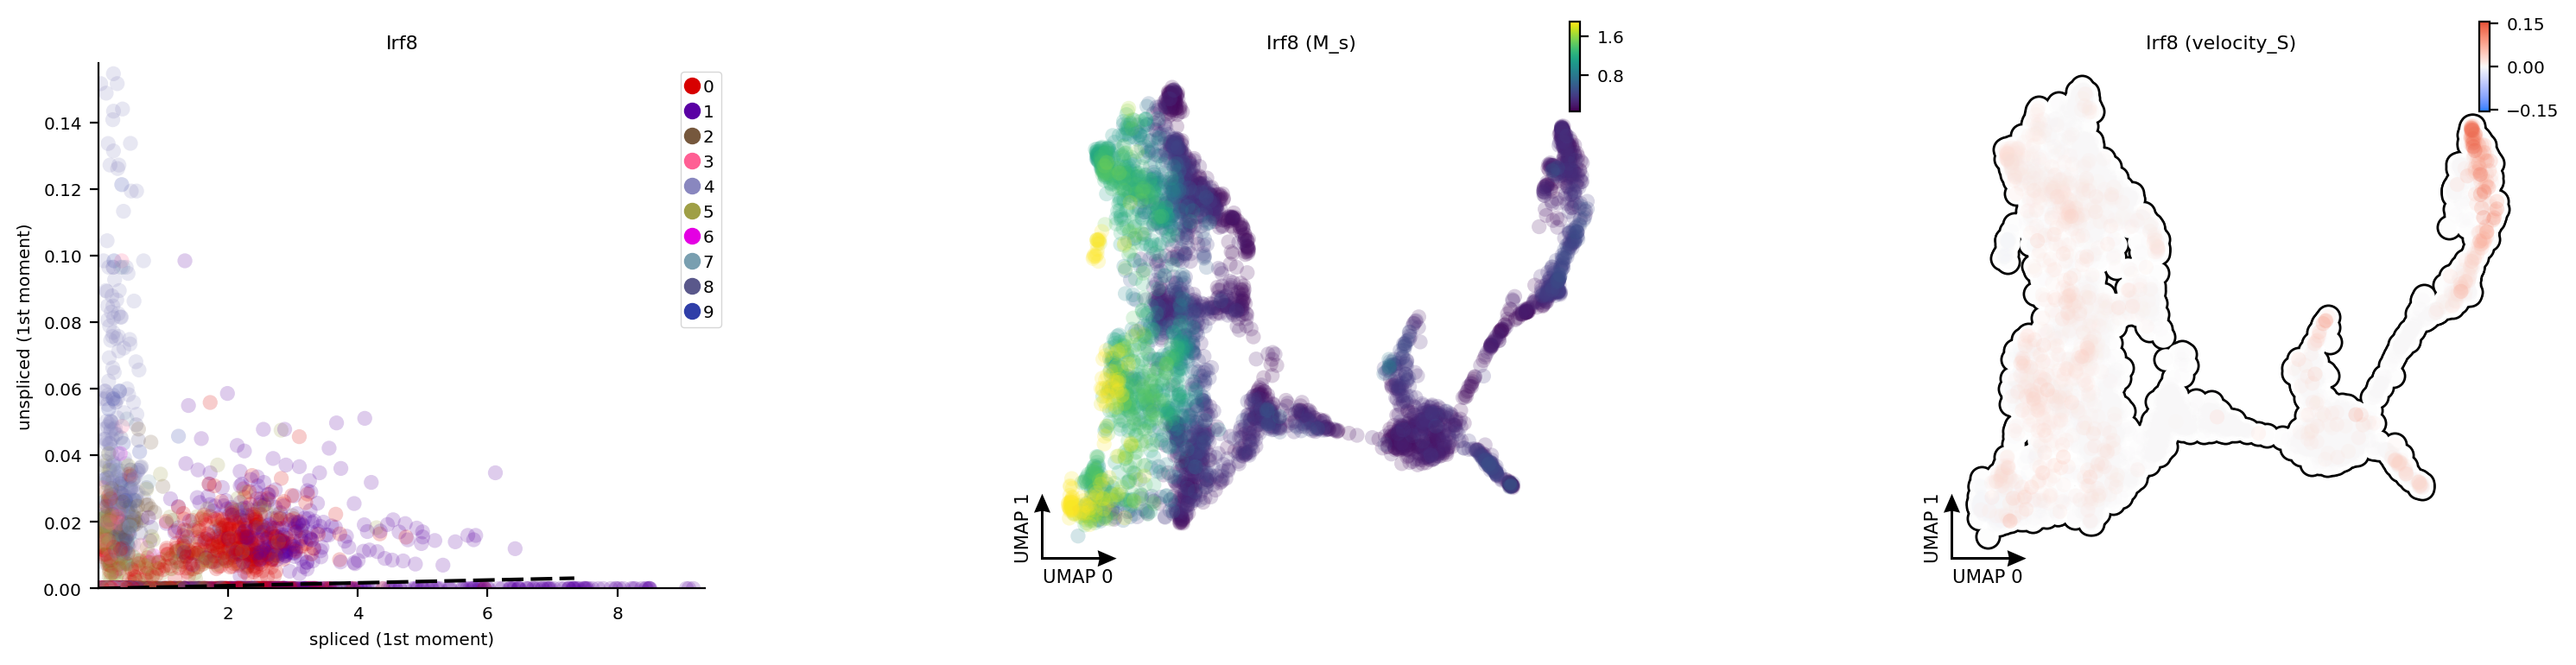

In [7]:
# estimate 𝛾 and calculate velocities
# the parameter `group` facilitate computing kinetics parameters for different lineages
adata = adata_bkup.copy()
dyn.tl.moments(adata, n_neighbors=50)
dyn.tl.dynamics(adata, model='stochastic', cores=10)

dyn.pl.phase_portraits(adata, genes=['Flt3'], figsize=(6, 4), color='leiden')
dyn.pl.phase_portraits(adata, genes=['Tcf4'], figsize=(6, 4), color='leiden')
dyn.pl.phase_portraits(adata, genes=['Gata3'], figsize=(6, 4), color='leiden')
dyn.pl.phase_portraits(adata, genes=['Id2'], figsize=(6, 4), color='leiden')
dyn.pl.phase_portraits(adata, genes=['Irf8'], figsize=(6, 4), color='leiden')



In [9]:
adata_bkup2 = adata.copy()

In [14]:
# Calculate UMAP. if already exists, skip
adata = adata_bkup2.copy()
dyn.tl.reduceDimension(adata)

lin_dict = {'5': ['1','6'],'6':["3"], '3':['9']}

dyn.tl.gene_wise_confidence(adata, group='leiden', lineage_dict=lin_dict)

# project velocity vectors to low-d embeddings
dyn.tl.cell_velocities(adata)
#dyn.tl.cell_velocities(adata, basis='pca')

# update adata.var["confident_genes"] and project cell_velocities with confident genes only
dyn.tl.confident_cell_velocities(adata, basis='umap', group='leiden', lineage_dict=lin_dict)
#dyn.tl.confident_cell_velocities(adata, basis='pca',  group='ann0608', lineage_dict={'αLP1.10': ['αLP1.7']})

dyn.vf.VectorField(adata, basis='umap', M=1000)

dyn.ext.ddhodge(adata, basis='umap', cores=2)


|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.4994s]


calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 1999it [00:49, 40.23it/s]


|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [4.4983s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.8836s]


calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 1999it [00:49, 40.14it/s]


|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [2.2394s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.8718s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [8.9571s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obs

# streamline plots

|-----------> plotting with basis key=X_umap


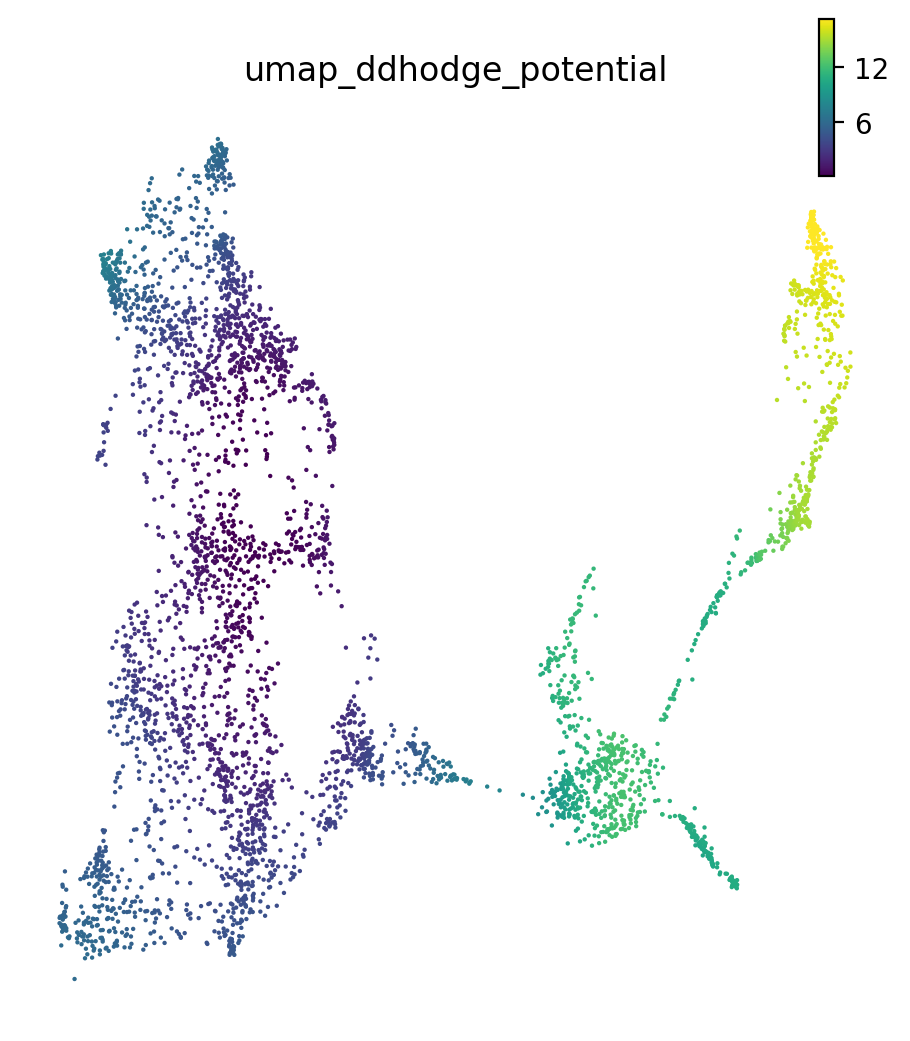

|-----> X shape: (4166, 2) V shape: (4166, 2)
|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type


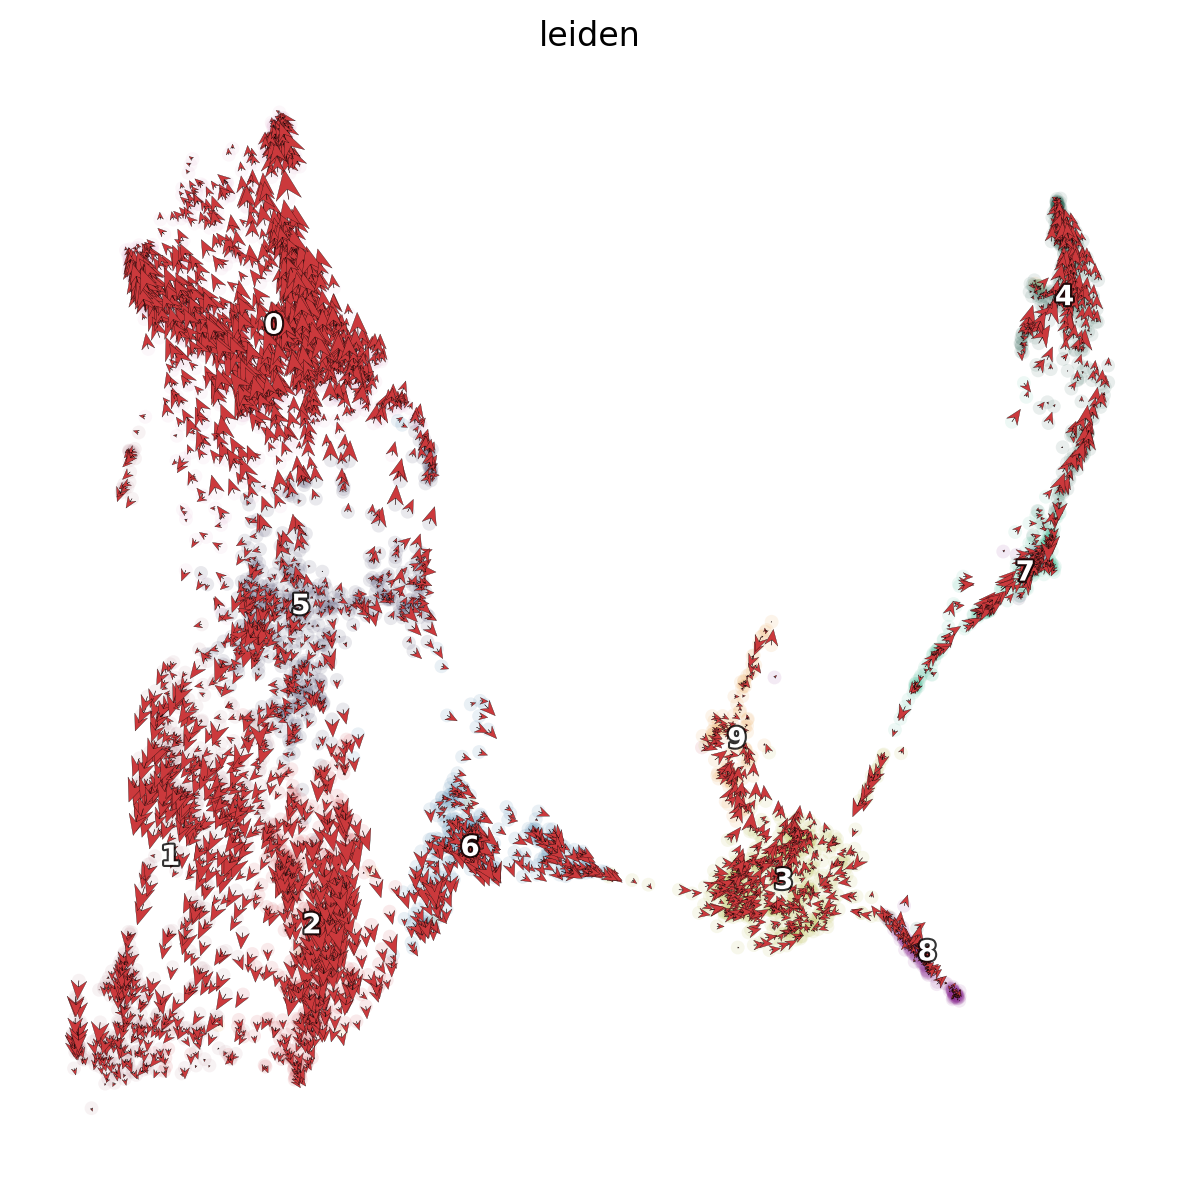

|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type


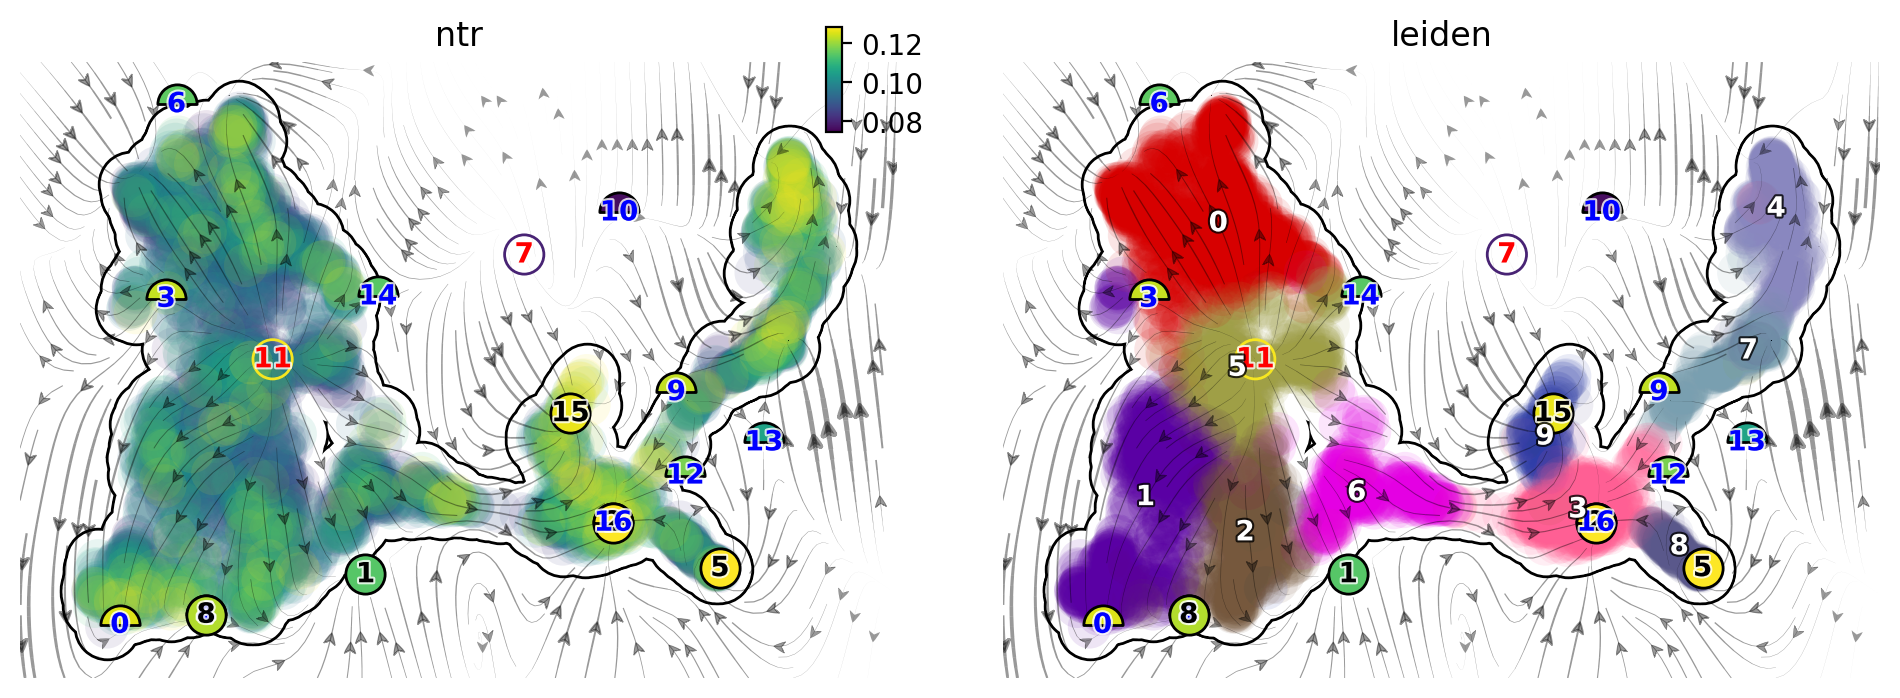

|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type


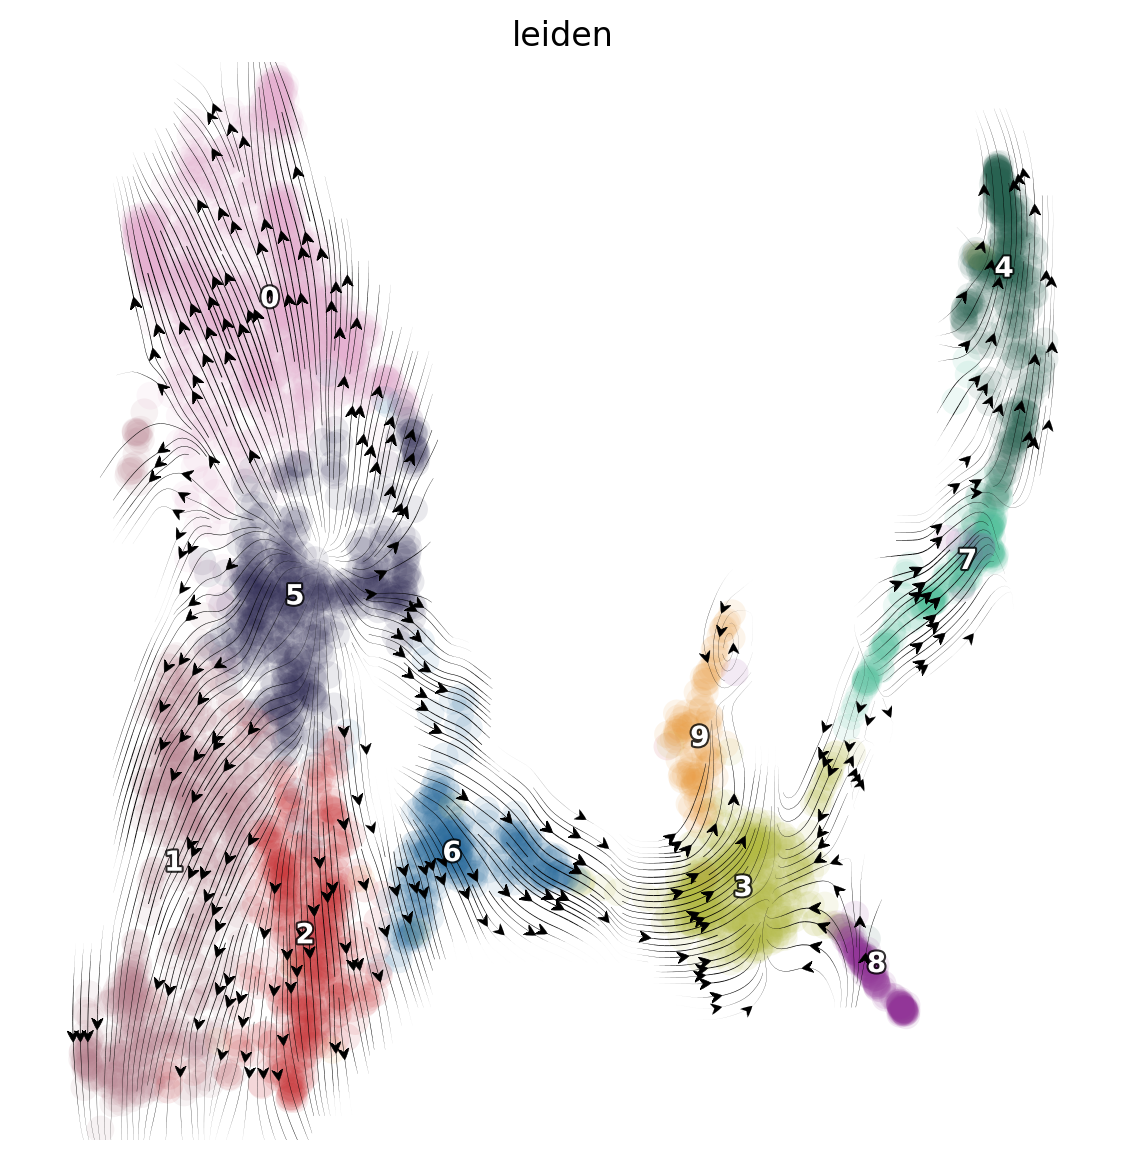

In [15]:
dyn.pl.umap(adata,  color='umap_ddhodge_potential', frontier=False, alpha=1, pointsize=0.01, figsize=[6,6])

dyn.pl.cell_wise_vectors(adata, color=['leiden'], 
                         basis='umap', show_legend='on data', 
                         quiver_length=6, quiver_size=6, pointsize=0.1, show_arrowed_spines=False,
                         color_key=palette, alpha=1, figsize=[6,6]
                        )

dyn.pl.topography(adata, basis='umap', background='white', 
                  color=['ntr', 'leiden'], streamline_color='black',
                  show_legend='on data', frontier=True)

dyn.pl.streamline_plot(adata, color='leiden', #aggregate='leiden',
                       alpha=1, #show_arrowed_spines=True,
                       density=3, linewidth=0.2, streamline_alpha=1, frontier=False,
                       pointsize=0.4, calpha=1,figsize=[7,7], 
                        save_show_or_return='show',
                        save_kwargs={"path":"./streamline-leiden",
                                     "prefix": '221103-FL', 
                                     "dpi": None, "ext": 'pdf', 
                                     "transparent": True, "close": True, "verbose": True},
                                     color_key=palette)


In [17]:
dyn.pl.streamline_plot(adata, color='leiden', #aggregate='leiden',
                       alpha=1, #show_arrowed_spines=True,
                       density=3, linewidth=0.2, streamline_alpha=1, frontier=False,
                       pointsize=0.4, calpha=1,figsize=[7,7], 
                        save_show_or_return='save',
                        save_kwargs={"path":"./streamline-leiden",
                                     "prefix": '221103-FL', 
                                     "dpi": None, "ext": 'svg', 
                                     "transparent": True, "close": True, "verbose": True},
                                     color_key=palette)


|-----------> plotting with basis key=X_umap
|-----------> skip filtering leiden by stack threshold when stacking color because it is not a numeric type
Saving figure to ./221103-FL_streamline-leiden.svg...
Done
